## NK Model

### Introduction

This notebook (...).

### Parameters and settings


All parameter settings and modeling choices go in this section.

In [22]:
# MODEL PARAMETERS
N = 4 # length of each genome
K_i = 2 # ruggedness parameter of the NK model for individual fitness
K_g = K_i # ruggedness parameter of the NK model for groups
G = 5 # number of groups
I = 100 # maximum number of individuals per group

init_I = 10 # intial total number of individuals 
alpha = 1/10 # generation time of groups relative to that of individuals 
t_end = 1000 # duration of simulation

# NEUTRALIY
"""
choose "NK" for regular NK, 
"NKp" for probabilistic NK, 
"NKq" for quantised NK
"""
neutrality_i = ["NK"] 
neutrality_g = ["NK"] 
p_i = 0.5 # p of NKp for individual-level fitness
p_g = p_i # p of NKp for group-level fitness
q_i = 4 # q of NKq for individual-level fitness
q_g = q_i # q of NKq for group-level fitness

# NETWORK PROPERTIES
"""
choose "r" for sampling with replacement, 
"nr" for without replacement, 
"block" for blockwise interactions
"""
network_i = ["r"]
network_g = ["r"]

# GROUPING SYSTEM
"""
choose "equal" for equal initial group sizes, 
"random" for random distribution of individuals amongst groups 
"""
grouping = ["equal"] 
# SIMULATION PARAMETERS
my_seed = 10 # random seed
t_end = 1000 # end time, in units of individual generation times.

### Packages

In [23]:
#import necessary packages
import numpy as np
import random as rd
from numpy.random import choice 
import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

#set style for all plots
plot.style.use("seaborn-v0_8-colorblind")

### Shorthands

Calculate shorthands that will be used throughout the simulation.

In [24]:
B_i = 2**(K_i + 1) # number of hypercube corners for the fitness contributions of each gene
# (= columns in fitness matrix) at the individual level 
B_g = 2**(K_g + 1) # number of hypercube corners for the fitness contributions of each gene
# (= columns in fitness matrix) at the group level

### Global variables

Define and create global variables that will be used thoughout the simulation.

In [25]:
# fitness matrix
fm_i = np.zeros((N, B_i)) # invullen: lege array N x B_j
fm_g = np.zeros((N, B_g)) # invullen: lege arry N x B_g

# epistasis matrices
val = list(range(0, N))

# (initial) genomes/coordinates individual and group level
ind_genomes = np.random.randint(0, 2, size = (I, N)) #randomly generates binary genomes for all individuals 
##ind_genomes_gr = #individuals grouped, not sure yet what smartest way is
#gr_genomes = np.mean(ind_genomes_gr, axis=0,) #takes avg of each column to generate group genome - exact method depends on grouping method
gr_genomes = np.random.rand(G, N) #randomly generates coordinates within hypercube for all individuals - replace by line above

# fitness values
#f_i = # absolute fitness individual level
f_i_comp = np.random.rand(I, N) #randomly generates fitness contributions associated with gene values of all individuals
f_i = np.mean(f_i_comp, axis=1,) #absolute fitness of all individuals (=avg by row of f_i_comp)
f_i = f_i.reshape(-1, 1) 
#f_g = # absolute fitness group level

#w_i = # relative fitness individual level

#w_g = # relative fitness group level

### Function definitions

#### ... for constructing epistasis matrix without repetition

In [26]:
#functions to create epistasis matrices without repeats
def generate_all_perm_tree(level, nums): 
    """
    makes tree structure with all possible permutations of given 'nums',
    where each number is allowed to move to next position in permutation, excluding repeats
    - level: Current level in the permutation.
    - nums (list): list of numbers to permute.
    returns:
    - dict: nested dictionary representing the permutation tree structure.
        Each key is a number, and corresponding value is the subtree for the next level.
    """
    if len(nums) == 1:
        if level == nums[0]:
            return None
        else:
            return {nums[0]: {}}
    allowed_number = list(nums)
    if level in allowed_number:
        allowed_number.remove(level)
    result = {}
    for number in allowed_number:
        sublevel_number = list(nums)
        if number in sublevel_number:
            sublevel_number.remove(number)
        subtree = generate_all_perm_tree(level + 1, sublevel_number)
        if subtree is not None:
            result[number] = subtree
    if len(result) == 0:
        return None
    return result

def pick_all_moved_perm(all_moved_perm_tree, picked=None):#picks permutation of numbers from previously generated tree, with each number selected only once
    """
    Picks permutation of numbers from previously generated tree, with each number selected only once
    - all_moved_perm_tree (dictionary): The permutation tree generated by generate_all_perm_tree
    - picked: set of numbers already picked.
    Return:
    - list: representing a permutation of numbers
    """
    if picked is None:
        picked = set()
    allowed_num_set = set(all_moved_perm_tree.keys()) - picked
    if not allowed_num_set:
        return []
    number = rd.choice(list(allowed_num_set))
    picked.add(number)
    l = [number]
    sub_tree = all_moved_perm_tree[number]
    if len(sub_tree) > 0:
        l.extend(pick_all_moved_perm(sub_tree, picked))
    return l

def generate_unique_r(tree, num_rows): 
    """
    Generates an array of unique pairs of numbers, with no number repeated in a row
    - tree (dict):the permutation tree generated by generate_all_moved_perm_tree.
    - num_rows: the number of rows to generate.
    Returns:
    - 2d array representing unique pairs of numbers in each row
    """
    result = []
    for _ in range(num_rows):
        row = list(zip(pick_all_moved_perm(tree), pick_all_moved_perm(tree)))
        while any(x[0] == x[1] for x in row):
            row = list(zip(pick_all_moved_perm(tree), pick_all_moved_perm(tree)))
        result.extend(row)
    return np.array(result[:num_rows])

#### ... for choosing preferred epistasis

In [27]:
def create_epistasis_matrix_i(): #epistasis matrix individual level
    em_i = []
    match network_i:
        case ["r"]:
            for row in range(N):
                val = list(range(0, N))
                gene_pair = rd.sample(val[:row] + val[row + 1:], K_i)  
                em_i.append([row] + gene_pair)
            em_i = np.array(em_i)  #first with own gene referenced
            em_i = em_i[:, 1:] #without own gene referenced #remove this row or above
        case ["nr"]:
            tree = generate_all_perm_tree(1, range(1, N+1))
            em_i = generate_unique_r(tree, N)
        #case ["block"]:
           # em = #working on it :)
    return em_i

def create_epistasis_matrix_g():
    em_g = []
    match network_g:
        case ["r"]:
            val = list(range(N))
            for row in range(N):
                gene_pair = rd.sample(val[:row] + val[row + 1:], K_g)  # Select K_g unique genes 
                em_g.append([row] + gene_pair)  # Row number added to the beginning
            em_g = np.array(em_g)  # First with own gene referenced
            em_g = em_g[:, 1:]
        case ["nr"]:
            tree = generate_all_perm_tree(1, range(1, N+1))
            em_g = generate_unique_r(tree, N)
        # case ["block"]:
        #    em = # working on it :)
    return em_g

#### ... for constructing fitness landscapes

In [28]:
def create_fitness_matrix_i():
    fm_i = np.random.rand(N, B_i)
    match neutrality_i:
        case ["NK"]:
            #
            pass
        case ["NKp"]:
            fm_i = np.where(np.random.rand(*fm_i.shape) < p_i, 0, fm_i) 
        case ["NKq"]:
            fm_i = np.digitize(fm_i, bins=np.linspace(0, 1, q_i+1), right=True) - 1
    return fm_i

def create_fitness_matrix_g():
    fm_g = np.random.rand(N, B_g)
    match neutrality_g:
        case ["NK"]:
            #
            pass
        case ["NKp"]:
            fm_g = np.where(np.random.rand(*fm_g.shape) < p_g, 0, fm_g) 
        case ["NKq"]:
            fm_g = np.digitize(fm_g, bins=np.linspace(0, 1, q_g+1), right=True) - 1
    return fm_g

#### ... for calculating coefficients (ai0 to aij)

In [29]:
def calc_a(fitness_matrix): #other functions split by ind/group but not this one. Do or not? think
    """
    calculate and return coefficients based on fitness matrix 
    - B: B_g or B_i: number of binary gene combinations = corners hypercube
    - fm (array): fm_g or fm_i - fitness matrix individuals or groups
    Returns:
    - List containing 'a' coefficients for each row of the input matrix
    """
    a_coefficients = []
    for r in fitness_matrix:
        a = [0.0] * B_g  # initialises list with zeros as floats for each row & X cols
        a[0] = r[0] #set ai0 to Fi0 
        for j in range(1, B_g): 
            sum = 0.0 
            # Calculate next coefs based only on previously calculated coefs
            for l in range(0, j): 
                #check if l equal to bitwise AND of l and j 
                #(ex: 001&101->001 TRUE; 001&100->000 FALSE)
                if l == (l & j): 
                    sum += a[l] 
            a[j] = r[j] - sum 
        a_coefficients.append(a) # append new a's into result array
    return a_coefficients

#### ... for calculating fitness values

In [30]:
def gene_fitness(coefficients, epistasis, genome, gene):
    """
    Calculate the fitness component of a specific gene in a genome
    - coefficients (array): coefficient matrix as calculated by calc_a
    - epistasis ("): Epistasis matrix representing interactions between genes
    - genome ("): genome values
    - gene (int): index of specific gene for which fitness component is calculated
    Returns:
    - fitness component of the specified gene in the genome (float)
    """
    result = 0

    for j in range(coefficients.shape[1]):
        contribution = coefficients[gene, j] * (genome[gene] ** (1 & j))
        for k in range(epistasis.shape[1]):
            epi_index = epistasis[gene, k]
            epi_value = genome[epi_index]
            product_term = epi_value ** ((2**(k+1) & j) / 2**(k+1))
            contribution *= product_term

        result += contribution
    return result

def genome_fitness(coefficients, epistasis, genome):
    """
    Calculate fitness components for all genes within a genome 
    return:
    array containing fitness components for each gene in the genome
    """
    fit_vals = np.zeros(len(genome))

    for gene in range(len(genome)):
        fit_vals[gene] = gene_fitness(coefficients, epistasis, genome, gene)
    return fit_vals

def calculate_fitness(coefficients, epistasis, genomes, num_genomes):
    """
    Calculate the fitness components for all genes in all genomes
    Return:
    2D array containing fitness components for each gene (cols) in each genome (rows)
    """
    fit_val = np.zeros((num_genomes, N))

    for group in range(num_genomes):
        fit_val[group, :] = genome_fitness(coefficients, epistasis, genomes[group])
    return fit_val


#### ... for running simulations

In [102]:
#individual genomes (initial only)
def ind_genomes(Ind): #include mutation in here if using?
    """
    Randomly generates binary genomes of length (N) for all individuals (I)
    Return: 
    2D array containing rows with genomes for all individuals
    """
    genomes = np.zeros((Ind, N))
    for individual in range(Ind):
        genomes[individual, :] = np.random.randint(0, 2, size = (N)) 
    return genomes  

#initial group membership
def choose_grouping(): 
    gr_index = []
    match grouping:
        case ["equal"]:
            repetitions = init_I // G
            remainder = init_I % G
            gr_index = np.repeat(np.arange(1, G+1), repetitions)

            if remainder > 0:
                extra_elements = np.random.choice(np.arange(1, G+1), remainder, replace=False)
                gr_index = np.concatenate([gr_index, extra_elements])
            np.random.shuffle(gr_index)
            gr_index = gr_index.reshape((init_I, 1))

        case ["random"]:
            gr_index = np.random.randint(1, G+1, size = (init_I, 1)) 
    return gr_index

#group genomes (initial only)
def gr_genomes(individual_genomes, group_membership):
    """
    Calculates average genome per group for use in continuous NK calc
    -ind_genomes (2d array): contains binary genome in each row for all individuals
    -group_membership (2d array): index that assigns each individual to a group indexed 1 to G
    Return: 
    2D array containing rows with genomes containing continuous gene values per gene for all groups
    """
    unique_gr_indices = np.unique(group_membership)
    group_genomes = np.zeros((len(unique_gr_indices), individual_genomes.shape[1]))

    for i, index in enumerate(unique_gr_indices):
        group_indices = np.where(group_membership == index)[0]
        if len(group_indices) > 0:
            group_values = individual_genomes[group_indices]
            group_genomes[i] = np.mean(group_values, axis=0)
        else:
            #if group is empty (no ind assigned to it), assign random member other group (right way to handle this?,
            #and could be done in group_membership outside of function?)
            random_member = np.random.choice(len(individual_genomes))
            group_genomes[i] = individual_genomes[random_member]

    return group_genomes

#def update_rates(): 
def update_ind_rates(absolute_ind_fitness, group_membership):
    """
    Calculates new event rates (= relative fitnesses) for individual reproduction 
    -absolute_fitnesses (2d array) = result of individual fitness function (fit_ind)
    -group_membership (2d array): index that assigns each individual to a group indexed 1 to G
    Return:
    array containing rates of reproduction for all individuals 
    """
    ind_rates = []
    index_set = set(group_membership.flatten())
    f_j = [np.mean(absolute_ind_fitness[group_membership==k]) for k in index_set]
    ind_rates = absolute_ind_fitness.flatten() / np.array([f_j[k-1] for k in group_membership.flatten()])
    ind_rates = ind_rates.reshape(-1, 1) 

    return ind_rates

def update_gr_rates(absolute_gr_fitness):
    """
    Calculates new event rates for group reproduction 
    -absolute_gr_fitness (2d array) = result of group fitness function (fit_ind)
    array containing rates of reproduction for all individuals 
    """
    F = np.mean(absolute_gr_fitness)
    W = absolute_gr_fitness / F
    gr_rates = alpha * W

    return gr_rates

def update_rates(absolute_ind_fitness, group_membership, absolute_gr_fitness): #could combine update_ind_rates, update_gr_rates, update_rates into one 
    """
    Combines individual and group rates into one array and adds ind/group event, and indexing by event type
    Return:
    2D array (total number of events, 3): event rates, individual/group 0/1, index of ind or group
    """
    ind_rates = update_ind_rates(absolute_ind_fitness, group_membership)
    individual = np.zeros_like(ind_rates) #individuals indicated by 0
    ind_index = np.arange(ind_rates.shape[0]).reshape(-1, 1) #index of which individual added
    ind_rates = np.column_stack((ind_rates, individual, ind_index)) 

    group_rates = update_gr_rates(absolute_gr_fitness)
    group = np.ones_like(group_rates) #groups indicated by 1
    group_index = np.arange(group_rates.shape[0]).reshape(-1, 1) #index of which group added
    group_rates = np.column_stack((group_rates, group, group_index)) 

    rates = np.vstack((ind_rates, group_rates))

    return rates

#still need to build in that group can only be selected when it contains specified number of inds, probably into gr_rates by only including rates of "available" groups
def choose_event(rates): 
    """
    -rates: 2D array (total number of events, 3): event rates, individual/group 0/1, index of ind or group
    Return:
    integer: index of selected event
    """
    rates_vals = rates[:, 0]
    event_index = np.arange(rates.shape[0])
    probs = rates_vals/sum(rates_vals)
    event_drawn = choice(event_index, 1, p=probs) #randomly selects event base on individual probabilities of each event

    return event_drawn

def individual_reproduction(event_drawn, rates, ind_genomes, group_membership): 
    """
    -event_drawn: index of selected event
    -rates: 2D array (total number of events, 3): event rates, individual/group 0/1, index of ind/inds or group/groups
    -ind_genomes: current individual genomes
    -group membership: index that assigns each individual to a group indexed 1 to G
    Return:
    -2D array (current total number of individuals, 2), with individual genomes and group membership in cols?
    """

#def group_splitting(): 

#def execute_reaction(event_drawn):
    #if event_drawn is individual -> individual_reproduction 
    #if event_drawn is group -> group_splitting 
    #do it so new fitness (and rate) calculation is only done for new individual/changed group or for the two new groups? 

### Tests

In [32]:
#parameters for testing multilinearity
ind = 1 #pick specific group based on group id 
I = 10 #number of iterations
varying_gene_vals = np.linspace(0, 1, 10)
constant_gene_vals = gr_genomes[ind-1, 1:]
var_gr_genome = np.column_stack([varying_gene_vals, np.tile(constant_gene_vals, (10, 1))]) #result is array of shape (10, N), with new values in first column and constant gr_genomes in other columns
fm_var = create_fitness_matrix_g()
coef_var = calc_a(fm_var)
a_shape = np.reshape(coef_var, (N, B_g))
coef_var = np.array(a_shape)
em_g_var = create_epistasis_matrix_g()
print(em_g_var)
#a_rep = np.tile(coef_var[ind-1], (100, 1)) #Create new array for a_shape with values selected genome repeated 100 times
#varying from 0,0,0,0 to 1,0,0,0
zero = np.zeros((1, N-1))
#var_gr_zero = np.column_stack([varying_gene_vals, np.tile(zero, (10, 1))])
var_gr_zero = np.column_stack([np.tile(zero, (10, 1)), varying_gene_vals])
print(var_gr_zero)

[[1 2]
 [0 2]
 [0 1]
 [1 2]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.11111111]
 [0.         0.         0.         0.22222222]
 [0.         0.         0.         0.33333333]
 [0.         0.         0.         0.44444444]
 [0.         0.         0.         0.55555556]
 [0.         0.         0.         0.66666667]
 [0.         0.         0.         0.77777778]
 [0.         0.         0.         0.88888889]
 [0.         0.         0.         1.        ]]


In [33]:
fit_var = calculate_fitness(coef_var, em_g_var, var_gr_zero, 10) #fitness components
avg_fit_var = np.mean(fit_var, axis=1) #average fitness
avg_fit_var = avg_fit_var.reshape(-1, 1)
#Binary representation of im 
im0 = np.arange(0, B_g, 1)
im1 = im0[np.newaxis, :]
im = np.repeat(im1, N, axis=0)
imbin = np.vectorize(np.binary_repr)(im, 3)

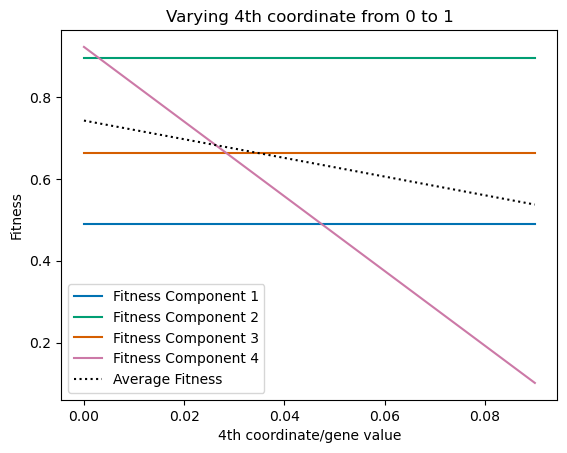

In [34]:
#visualisation for multilinearity test
for i in range(fit_var.shape[1]):
    plot.plot(np.array(range(len(fit_var))) / 100, fit_var[:, i], label=f'Fitness Component {i + 1}')

# Plot average fitness as a dotted line
plot.plot(np.array(range(len(fit_var))) / 100, avg_fit_var, color='k', linestyle='dotted', label='Average Fitness')

plot.xlabel('4th coordinate/gene value')
plot.ylabel('Fitness')
plot.title('Varying 4th coordinate from 0 to 1')
plot.legend()
plot.show() #all fitness components should change linearly

In [35]:
#maybe do later: varying two coords
#num_points = 100 
#x1_values = np.linspace(0, 1, num_points)
#x2_values = np.linspace(0, 1, num_points)
#meshgrid from x1 and x2 values
#x1, x2 = np.meshgrid(x1_values, x2_values)
#x3 = 
#grid_coords = np.column_stack([x1.flatten(), x2.flatten(), np.full_like(x1.flatten(), x3)])


## The simulation

In [36]:
# INITIALISATION
rd.seed(my_seed) # set random seed

# CONSTRUCT FITNESS LANDSCAPES 
fm_i = create_fitness_matrix_i()
fm_g = create_fitness_matrix_g()
# Construct epistasis matrices
em_i = create_epistasis_matrix_i()
em_g = create_epistasis_matrix_i()
#coefficients
coef_i = np.array(calc_a(fm_i))
coef_g = np.array(calc_a(fm_g))
#grouping
init_gr_index = choose_grouping()

# INIITIALIZE
init_ind_genomes = ind_genomes(init_I) #initial individual genomes 
fit_ind_gene = calculate_fitness(coef_i, em_i, ind_genomes, init_I) #fitness components
fit_ind = np.mean(fit_ind_gene, axis=1) #average fitness
fit_ind = fit_ind.reshape(-1, 1)

init_gr_genomes = gr_genomes(init_ind_genomes, init_gr_index) #initial group genomes
fit_gr_gene = calculate_fitness(coef_g, em_g, init_gr_genomes, G) #fitness components
fit_gr = np.mean(fit_gr_gene, axis=1) #average fitness
fit_gr = fit_gr.reshape(-1, 1)

t = 0

In [104]:
# RUN SIMULATIONS
while t < t_end :
    rates = update_rates()
    propensity = sum(rates)
    tau = np.random.exponential(scale=1 / propensity) # waiting time for next reaction
    t = t + tau
    event = choose_event(rates)
    execute_reaction(event)


TypeError: update_rates() missing 3 required positional arguments: 'absolute_ind_fitness', 'group_membership', and 'absolute_gr_fitness'

## Results